In [1]:
import os
import cv2
import numpy as np

#prepares data for preprocessing
def prepare_data(frames, input_len=10, output_len=10):

    X, Y = [], []
    total_frames = len(frames)

    for i in range(total_frames - input_len - output_len + 1):
        # Input frames
        X.append(frames[i : i + input_len])

        # Output frames
        Y.append(frames[i + input_len : i + input_len + output_len])

    # Grayscaling and numpy array conversions
    X = np.expand_dims(np.array(X), axis=-1)  
    Y = np.expand_dims(np.array(Y), axis=-1) 
    return X, Y

# Function to extract the first 20 frames from a video
def extract_frames(video_path, frame_size, num_frames=20):
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Failed to open video: {video_path}")
            return frames

        # Extraction takes place here
        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret:
                break  #exception break
            frame_resized = cv2.resize(frame, frame_size)
            frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
            frames.append(frame_gray)
        cap.release()

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
    
    return frames

# Function to process all videos and prepare the dataset
def prepare_dataset(folder_path, input_length, output_length, frame_size):
    X, Y = [], []
    video_files = os.listdir(folder_path)
    print(f"Found {len(video_files)} videos in {folder_path}.")
    
    # Initialize frames as an empty list
    jumpingjack_frames = []
    
    for video_name in video_files:
        video_path = os.path.join(folder_path, video_name)
        if not os.path.exists(video_path):
            print(f"Video does not exist: {video_name}")
            continue
        
        print(f"Processing video: {video_name}")
        frames = extract_frames(video_path, frame_size, num_frames=20)  
        
        if len(frames) < input_length + output_length:
            print(f"Skipping {video_name}: insufficient frames ({len(frames)} frames).")
            continue
        
        jumpingjack_frames.append(frames)  

    return jumpingjack_frames


dataset_path = "/kaggle/input/ucf101-action-recognition"
jumping_jacks_folder = "train/BoxingPunchingBag"
folder_="train/JumpingJack"
folder2="train/PullUps"
folder3="train/SkyDiving"
folder4="train/ApplyLipstick"

input_sequence_length = 10
output_sequence_length = 5
frame_size = (64, 64)

# Get the first 20 frames
folder_path = os.path.join(dataset_path, jumping_jacks_folder)
jumpingjack_frames = prepare_dataset(folder_path, input_sequence_length, output_sequence_length, frame_size)


all_video_frames = [frame for video in jumpingjack_frames for frame in video]  # Flatten all videos

input_len = 10
output_len = 10 


X, Y = prepare_data(all_video_frames, input_len=input_len, output_len=output_len)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")


Found 122 videos in /kaggle/input/ucf101-action-recognition/train/BoxingPunchingBag.
Processing video: v_BoxingPunchingBag_g01_c05.avi
Processing video: v_BoxingPunchingBag_g22_c07.avi
Processing video: v_BoxingPunchingBag_g09_c03.avi
Processing video: v_BoxingPunchingBag_g17_c04.avi
Processing video: v_BoxingPunchingBag_g14_c02.avi
Processing video: v_BoxingPunchingBag_g06_c07.avi
Processing video: v_BoxingPunchingBag_g19_c01.avi
Processing video: v_BoxingPunchingBag_g12_c04.avi
Processing video: v_BoxingPunchingBag_g05_c05.avi
Processing video: v_BoxingPunchingBag_g07_c06.avi
Processing video: v_BoxingPunchingBag_g02_c04.avi
Processing video: v_BoxingPunchingBag_g01_c06.avi
Processing video: v_BoxingPunchingBag_g01_c03.avi
Processing video: v_BoxingPunchingBag_g12_c05.avi
Processing video: v_BoxingPunchingBag_g23_c01.avi
Processing video: v_BoxingPunchingBag_g16_c07.avi
Processing video: v_BoxingPunchingBag_g20_c03.avi
Processing video: v_BoxingPunchingBag_g03_c02.avi
Processing vide

In [2]:
from keras.layers import Conv3D, ConvLSTM2D, Input, TimeDistributed, Flatten, Dense
from keras.models import Model

def build_predrnn(input_shape):

    inputs = Input(shape=input_shape)

    # First ConvLSTM2D layer for spatial-temporal modeling
    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu"
    )(inputs)

    # 3D Convolutional layer for temporal prediction
    x = Conv3D(
        filters=64,
        kernel_size=(3, 3, 3),  #temporal depth, height, width
        padding="same",
        activation="relu"
    )(x)

    # Output layer is 3D Convolutional Layer
    outputs = Conv3D(
        filters=1,  # Output channels in gray
        kernel_size=(3, 3, 3),
        padding="same",
        activation="tanh"
    )(x)

    # Create  model
    model = Model(inputs, outputs)
    return model


# Build
input_shape = (input_sequence_length, 64, 64, 1)  # 10 frames of 64x64 with 1 channel (grayscale)
model = build_predrnn(input_shape)

# Summary 
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 64, 64, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 10, 64, 64, 64) │       150,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 10, 64, 64, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 64, 64, 1)  │         1,729 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,401 (1.00 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:

def prepare_data(frames, input_len=10, output_len=5):
    X, Y = [], []
    total_frames = len(frames)

    for i in range(total_frames - input_len - output_len + 1):
        # Inputof 10 frames
        X.append(frames[i : i + input_len])

        # Output next 5 frames
        Y.append(frames[i + input_len : i + input_len + output_len])

  #numpy + grayscale array conversion
    X = np.expand_dims(np.array(X), axis=-1)  
    Y = np.expand_dims(np.array(Y), axis=-1)  
    return X, Y
    
all_video_frames = [frame for video in jumpingjack_frames for frame in video]  # Flatten all videos
input_len = 10
output_len = 10 

X, Y = prepare_data(all_video_frames, input_len=10, output_len=10)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")


X shape: (2421, 10, 64, 64, 1), Y shape: (2421, 10, 64, 64, 1)


In [4]:
# Compile the model
output_len = 10  
model.compile(
    optimizer="adam",
    loss="mse",  # Mean Squared Error
    metrics=["mae"]  # Mean Absolute Error
)

# Train the model
history = model.fit(
    X, Y,
    epochs=20, 
    batch_size=8,  
    validation_split=0.2 
)
model.save("predrnn.h5")

Epoch 1/20


I0000 00:00:1733155641.868550     585 service.cc:145] XLA service 0x790da8026a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733155641.868596     585 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733155641.868599     585 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/242 ━━━━━━━━━━━━━━━━━━━━ 36:36 9s/step - loss: 0.1910 - mae: 0.3661

I0000 00:00:1733155649.131845     585 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


242/242 ━━━━━━━━━━━━━━━━━━━━ 56s 195ms/step - loss: 0.0778 - mae: 0.2206 - val_loss: 0.0605 - val_mae: 0.1985
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - loss: 0.0596 - mae: 0.1930 - val_loss: 0.0571 - val_mae: 0.1848
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - loss: 0.0584 - mae: 0.1901 - val_loss: 0.0560 - val_mae: 0.1814
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 49s 203ms/step - loss: 0.0594 - mae: 0.1916 - val_loss: 0.0560 - val_mae: 0.1870
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 51s 210ms/step - loss: 0.0587 - mae: 0.1910 - val_loss: 0.0564 - val_mae: 0.1898
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 51s 210ms/step - loss: 0.0580 - mae: 0.1896 - val_loss: 0.0556 - val_mae: 0.1811
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - loss: 0.0569 - mae: 0.1866 - val_loss: 0.0550 - val_mae: 0.1824
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - loss: 0.0553 - mae: 0.1832 - val_loss: 0.0558 - val_mae: 0.1808
Epoch 9/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 51s

I0000 00:00:1733255393.986475      97 service.cc:145] XLA service 0x78be480b7af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733255393.986532      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733255393.986537      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1733255395.689621      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


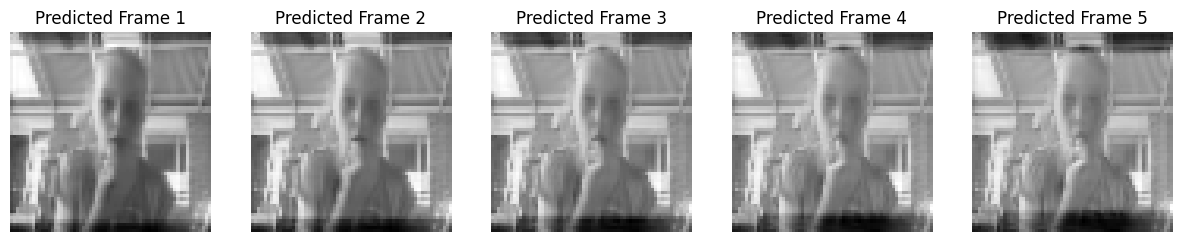

In [1]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.metrics import MeanSquaredError

# Function to extract frames from a video
def extract_frames(video_path, frame_size=(64, 64)):
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Failed to open video: {video_path}")
            return frames

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, frame_size)
            frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
            frames.append(frame_gray)
        cap.release()

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
    
    return frames

# Load the trained model
custom_objects = {
    'mse': MeanSquaredError() 
}

# Load the model with custom_objects
model_path = '/kaggle/input/applylipstick/keras/default/1/ApplyLipstick_predrnn.h5'
model = load_model(model_path, custom_objects=custom_objects)

# Test video path
test_video_path = '/kaggle/input/ucf101-action-recognition/test/ApplyLipstick/v_ApplyLipstick_g03_c01.avi'
frames = extract_frames(test_video_path)

input_len = 10
if len(frames) >= input_len:
    test_frames = frames[:input_len]
else:
    print(f"Not enough frames in the test video. Found {len(frames)} frames.")
    test_frames = frames

test_frames = np.expand_dims(test_frames, axis=-1) 
predicted_frames = model.predict(np.expand_dims(test_frames, axis=0)) 

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):  # Show the first 5 predicted frames
    ax = axes[i]
    ax.imshow(predicted_frames[0, i, :, :, 0], cmap="gray") 
    ax.set_title(f"Predicted Frame {i+1}")
    ax.axis("off")

plt.show()


In [13]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from keras.metrics import MeanSquaredError

# Function to extract frames from the test video
def extract_frames(video_path, frame_size=(64, 64)):
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Failed to open video: {video_path}")
            return frames

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, frame_size)
            frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
            frames.append(frame_gray)
        cap.release()

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
    
    return np.array(frames)  # Ensure frames are returned as a NumPy array

# Function to create a transition video
def create_transition_video(input_seq, predicted_seq, output_filename, duration=5, fps=20):

    frames = []
    total_frames = duration * fps
    
    # Add input frames to the video sequence
    for i in range(len(input_seq)):
        input_frame = input_seq[i, :, :, 0]
        input_frame = (input_frame * 255).astype(np.uint8)  # Normalize and convert to uint8
        input_frame_color = cv2.cvtColor(input_frame, cv2.COLOR_GRAY2BGR) 
        frames.append(input_frame_color)
    
    # Add predicted frames to the video sequence
    for i in range(len(predicted_seq)):
        pred_frame = predicted_seq[i, :, :, 0]
        pred_frame = (pred_frame * 255).astype(np.uint8)  # Normalize and convert to uint8
        pred_frame_color = cv2.cvtColor(pred_frame, cv2.COLOR_GRAY2BGR)  
        frames.append(pred_frame_color)

   
    if len(frames) < total_frames:
        frames = frames * (total_frames // len(frames) + 1)  # Repeat the frames enough timesnfor sandwiching

    #trimming
    frames = frames[:total_frames]
    
    # Get the dimensions of the frame
    height, width = frames[0].shape[:2]
    
    fourcc = cv2.VideoWriter_fourcc(*'DIVX') 
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))
    
    # Write frames to the video
    for frame in frames:
        out.write(frame)
    
    # Release the video writer
    out.release()
    print(f"Generated video saved as {output_filename}")


custom_objects = {
    'mse': MeanSquaredError()  # Register the metric
}

# Load the model with custom_objects
model_path = '/kaggle/input/pullups/keras/default/1/pullups_predrnn.h5'
model = load_model(model_path, custom_objects=custom_objects)
test_video_path = '/kaggle/input/ucf101-action-recognition/test/PullUps/v_PullUps_g07_c04.avi'


frames = extract_frames(test_video_path)
input_len = 10
test_frames = frames[:input_len]  


test_frames = np.expand_dims(test_frames, axis=-1) 
predicted_frames = model.predict(np.expand_dims(test_frames, axis=0)) 
predicted_frames = predicted_frames.squeeze(axis=0) 

output_merged_video_path = "generated_transition_video3.avi"
create_transition_video(test_frames, predicted_frames, output_merged_video_path, duration=5, fps=20)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Generated video saved as generated_transition_video3.avi


In [12]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from keras.metrics import MeanSquaredError


def extract_frames(video_path, frame_size=(64, 64)):
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Failed to open video: {video_path}")
            return frames

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, frame_size)
            frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
            frames.append(frame_gray)
        cap.release()

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
    
    return np.array(frames) 

# Function to create a transition video
def create_transition_video(input_seq, predicted_seq, output_filename, duration=5, fps=20):
    """Generate a video showing input frames first, followed by predicted frames."""

    frames = []
    
    total_frames = duration * fps
    
    # Add input frames to the video sequence
    for i in range(len(input_seq)):
        input_frame = input_seq[i, :, :, 0]
        input_frame = (input_frame * 255).astype(np.uint8)  # Normalize and convert to uint8
        input_frame_color = cv2.cvtColor(input_frame, cv2.COLOR_GRAY2BGR)  
        frames.append(input_frame_color)
    
    # Add predicted frames to the video sequence
    for i in range(len(predicted_seq)):
        pred_frame = predicted_seq[i, :, :, 0]
        pred_frame = (pred_frame * 255).astype(np.uint8)  # Normalize and convert to uint8
        pred_frame_color = cv2.cvtColor(pred_frame, cv2.COLOR_GRAY2BGR) 
        frames.append(pred_frame_color)


    if len(frames) < total_frames:
        frames = frames * (total_frames // len(frames) + 1)  # Repeat the frames for sandwiching
    
    # Trim frames
    frames = frames[:total_frames]
    height, width = frames[0].shape[:2]
    
    fourcc = cv2.VideoWriter_fourcc(*'DIVX') 
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))
    
    # Write frames to the video
    for frame in frames:
        out.write(frame)
    
    # Release the video writer
    out.release()
    print(f"Generated video saved as {output_filename}")


custom_objects = {
    'mse': MeanSquaredError()  # Register the metric
}

# Load the model
model_path = '/kaggle/input/pullups/keras/default/1/pullups_predrnn.h5'
model = load_model(model_path, custom_objects=custom_objects)
test_video_path = '/kaggle/input/ucf101-action-recognition/test/PullUps/v_PullUps_g07_c04.avi'


frames = extract_frames(test_video_path)
input_len = 10
test_frames = frames[:input_len]  # Use the first 10 frames

test_frames = np.expand_dims(test_frames, axis=-1) 

# Predict the next frames (using the trained model)
predicted_frames = model.predict(np.expand_dims(test_frames, axis=0)) 
predicted_frames = predicted_frames.squeeze(axis=0)  

output_merged_video_path = "generated_transition_video2.avi"
create_transition_video(test_frames, predicted_frames, output_merged_video_path, duration=5, fps=20)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
Generated video saved as generated_transition_video2.avi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

In [9]:
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import numpy as np
from skimage.metrics import structural_similarity as sk_ssim
from tensorflow.keras.models import load_model
from keras.metrics import MeanSquaredError
import cv2
import os


custom_objects = {
    'mse': MeanSquaredError() 

model_path = '/kaggle/input/boxing/keras/default/1/boxingbag_predrnn.h5'
model = load_model(model_path, custom_objects=custom_objects)

def extract_frames_from_video(video_path, frame_size=(64, 64)):

    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Failed to open video: {video_path}")
            return frames

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Resize, grayscale, and normalize frames
            frame_resized = cv2.resize(frame, frame_size)
            frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
            frames.append(frame_gray)
        cap.release()

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
    
    return frames

def load_test_dataset(test_video_dir, input_seq_len, pred_seq_len):

    test_input, test_target = [], []
    for video_file in os.listdir(test_video_dir):
        video_path = os.path.join(test_video_dir, video_file)
        frames = extract_frames_from_video(video_path)
        
        for i in range(len(frames) - input_seq_len - pred_seq_len):
            input_frames = frames[i:i + input_seq_len]
            target_frames = frames[i + input_seq_len:i + input_seq_len + pred_seq_len]
            test_input.append(np.array(input_frames))
            test_target.append(np.array(target_frames))
    
    test_input = np.array(test_input).astype("float32")  # Normalize to [0, 1]
    test_input = np.expand_dims(test_input, -1)  # Add channel dimension

    test_target = np.array(test_target).astype("float32")
    test_target = np.expand_dims(test_target, -1)  # Add channel dimension
    
    return test_input, test_target

# Specify the test video directory path
test_video_dir = '/kaggle/input/ucf101-action-recognition/test/BoxingPunchingBag'

# Load test data
input_sequence_length = 10
predicted_sequence_length = 5
test_input, test_target = load_test_dataset(test_video_dir, input_sequence_length, predicted_sequence_length)


predicted_frames = model.predict(test_input)


mse_scores = []
ssim_scores = []

for i in range(len(test_target)):
    for j in range(predicted_sequence_length):
        target_frame = test_target[i, j, :, :, 0]  # Remove channel dimension for SSIM
        predicted_frame = predicted_frames[i, j, :, :, 0]  # Remove channel dimension for SSIM
        
        # Calculate MSE
        mse = mean_squared_error(target_frame.flatten(), predicted_frame.flatten())
        mse_scores.append(mse)
        
        # Calculate SSIM
        ssim = sk_ssim(target_frame, predicted_frame, data_range=1.0)  # SSIM requires 2D inputs
        ssim_scores.append(ssim)


avg_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

avg_ssim = np.mean(ssim_scores)
std_ssim = np.std(ssim_scores)


print(f"Average MSE: {avg_mse}")
print(f"Standard Deviation of MSE: {std_mse}")
print(f"Average SSIM: {avg_ssim}")
print(f"Standard Deviation of SSIM: {std_ssim}")


117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step
Average MSE: 0.036114320158958435
Standard Deviation of MSE: 0.012519823387265205
Average SSIM: 0.4449076093660794
Standard Deviation of SSIM: 0.12567332292306377
